In [14]:
from __future__ import print_function
from mpl_toolkits.mplot3d import Axes3D
import pywavefront
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import timeit
import multiprocessing as mp

In [15]:
scene = pywavefront.Wavefront('swift-2-in_mesh.obj')
data = np.array(scene.vertices)
print(data.shape)

(26756, 3)


In [16]:
def column(matrix, i):
    return np.array([row[i] for row in matrix])

In [17]:
def roundAxis(data,axis):
    for i in range(len(data)):
        data[i][axis] = int(data[i][axis]/10)*10
    data = sorted(data, key = lambda x:x[axis])
    return data

In [18]:
def createIndex(data,step):
    i = 0
    value = np.amin(data)
    up = np.amax(data)
    index=[0]
    while value <= up:
        while i < len(data) and data[i] <= value:
            i+=1
        index.append(i-1)
        value +=step
    index.append(len(data)-1)
    return index

In [19]:
data_roundX = data.copy()
data_roundX = roundAxis(data_roundX,0)
x_train_X = column(data_roundX,0).reshape(-1,1)
y_train_X = column(data_roundX,1).reshape(-1,1)
z_train_X = column(data_roundX,2).reshape(-1,1)

X_train_X = np.hstack((x_train_X,y_train_X))

In [20]:
data_roundY = roundAxis(data,1)
x_train_Y = column(data_roundY,0).reshape(-1,1)
y_train_Y = column(data_roundY,1).reshape(-1,1)
z_train_Y = column(data_roundY,2).reshape(-1,1)

X_train_Y = np.hstack((x_train_Y,y_train_Y))

In [21]:
x_index = createIndex(x_train_X,10)
y_index = createIndex(y_train_Y,10)

In [22]:
x_index

[0,
 49,
 639,
 1586,
 2708,
 3950,
 5212,
 6517,
 7891,
 9317,
 10636,
 11887,
 13121,
 14533,
 15807,
 17198,
 18622,
 19966,
 21253,
 22496,
 23706,
 24819,
 25786,
 26513,
 26755,
 26755]

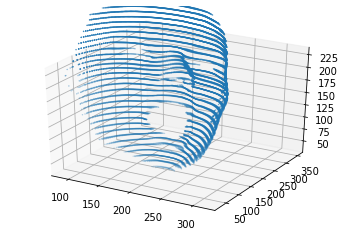

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_Y, y_train_Y, z_train_Y,zdir="y",s =0.1)

In [24]:
learning_rate = 0.01
epsilon = 1
batch_size = 100
display_step = 100

x = tf.placeholder(tf.float32,[None, 2])
y = tf.placeholder(tf.float32, [None, 1])

W1 = tf.Variable(tf.random.normal([2,16]),tf.float32)
b1 = tf.Variable(tf.zeros([16]),tf.float32)
W2 = tf.Variable(tf.random.normal([16,32]),tf.float32)
b2 = tf.Variable(tf.zeros([32]),tf.float32)
W3 = tf.Variable(tf.random.normal([32,1]),tf.float32)
b3 = tf.Variable(tf.zeros([1]),tf.float32)

In [25]:
x = tf.nn.dropout(x, keep_prob =0.8)
Z1 = tf.add(tf.matmul(x,W1),b1)
A1 = tf.nn.relu(Z1)

Z2 = tf.add(tf.matmul(A1,W2),b2)
A2 = tf.nn.relu(Z2)

Z3 = tf.add(tf.matmul(A2,W3),b3)
cost = tf.reduce_mean(tf.pow(y-Z3,2))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Epoch: 5002 line= 000 cost= 134.456985474
Epoch: 5002 line= 001 cost= 752.040222168
Epoch: 5002 line= 002 cost= 53.646728516
Epoch: 5002 line= 003 cost= 28.175252914
Epoch: 5002 line= 004 cost= 14.946076393
Epoch: 5002 line= 005 cost= 9.374542236
Epoch: 5002 line= 006 cost= 5.783278942
Epoch: 5002 line= 007 cost= 9.188017845
Epoch: 5002 line= 008 cost= 8.855003357
Epoch: 5002 line= 009 cost= 10.023058891
Epoch: 5002 line= 010 cost= 13.447728157
Epoch: 5002 line= 011 cost= 2.792765617
Epoch: 5002 line= 012 cost= 4.810713768
Epoch: 5002 line= 013 cost= 11.533951759
Epoch: 5002 line= 014 cost= 8.151659966
Epoch: 5002 line= 015 cost= 4.255715370
Epoch: 5002 line= 016 cost= 3.494386196
Epoch: 5002 line= 017 cost= 4.614387989
Epoch: 5002 line= 018 cost= 7.721540451
Epoch: 5002 line= 019 cost= 11.599693298
Epoch: 5002 line= 020 cost= 18.048398972
Epoch: 5002 line= 000 cost= 7.575239182
Epoch: 5002 line= 001 cost= 25.088983536
Epoch: 5002 line= 002 cost= 2.440083981
Epoch: 5002 line= 003 cost=

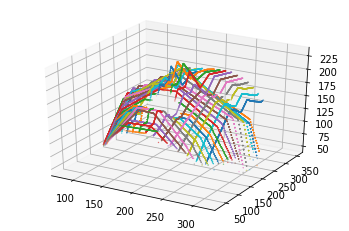

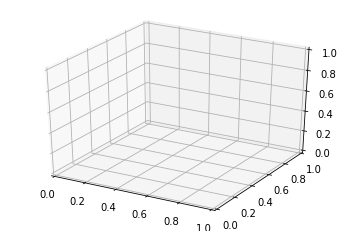

In [26]:
fig = plt.figure()
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-5,5)
ax = fig.add_subplot(111, projection='3d')
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')

with tf.Session() as sess :
    sess.run(init)
    i = 0
    cost_L=[]
    epoch_L=[]
    while i <= 20:
        epoch = 0
        c_x = 10
        while epoch <= 5000 and c_x > epsilon:
            X = X_train_X[x_index[i]:x_index[i+1]]
            Y = z_train_X[x_index[i]:x_index[i+1]]
            _,c_x=sess.run([optimizer,cost],feed_dict={x:X, y:Y})
            epoch += 1
        print("Epoch:", '%04d' % (epoch+1), "line=", '%03d'%i, "cost=", "{:.9f}".format(c_x))
        ax.scatter(x_train_X[x_index[i]:x_index[i+1]],y_train_X[x_index[i]:x_index[i+1]],sess.run(Z3,feed_dict={x:X,y:Y}),s=0.1)
        i+=1
    i=0
    while i <= 20:
        epoch = 0
        c_y = 10
        while epoch <= 5000 and c_y > epsilon:
            X = X_train_Y[y_index[i]:y_index[i+1]]
            Y = z_train_Y[y_index[i]:y_index[i+1]]
            _,c_y=sess.run([optimizer,cost],feed_dict={x:X, y:Y})
            epoch += 1
        print("Epoch:", '%04d' % (epoch+1), "line=", '%03d'%i, "cost=", "{:.9f}".format(c_y))
        ax.scatter(x_train_Y[y_index[i]:y_index[i+1]],y_train_Y[y_index[i]:y_index[i+1]],sess.run(Z3,feed_dict={x:X,y:Y}),s=0.1)
        i+=1
    #ax2.scatter(x_train,y_train,z_train)
    ##y = sess.run(Z3,feed_dict={x:x_test})
    print("Optimization Finished!")

In [13]:
def fitSingleLine(sess,i,axis):
    if axis == 'x':
        cost_L = []
        epoch_L = []
        epoch = 0
        c_x = 10
        while epoch <= 500 and c_x > epsilon:
            X = X_train_X[x_index[i]:x_index[i+1]]
            Y = z_train_X[x_index[i]:x_index[i+1]]
            _,c_x=sess.run([optimizer,cost],feed_dict={x:X, y:Y})
            epoch += 1
            if (epoch % 100 == 0):
                cost_L.append(c_x)
                epoch_L.append(epoch)
        plt.plot(epoch_L, cost_L)
        print("Epoch:", '%04d' % (epoch+1), "line=", '%03d'%i, "cost=", "{:.9f}".format(c_x))
        ax.scatter(x_train_X[x_index[i]:x_index[i+1]],y_train_X[x_index[i]:x_index[i+1]],sess.run(Z3,feed_dict={x:X,y:Y}),s=0.1,zdir='y')   
    if axis == 'y':
        epoch = 0
        c_y = 10
        while epoch <= 500 and c_y > epsilon and i < len(y_index):
            X = X_train_Y[y_index[i]:y_index[i+1]]
            Y = z_train_Y[y_index[i]:y_index[i+1]]
            _,c_y=sess.run([optimizer,cost],feed_dict={x:X, y:Y})
            epoch += 1
        print("Epoch:", '%04d' % (epoch+1), "line=", '%03d'%i, "cost=", "{:.9f}".format(c_y))
        ax.scatter(x_train_Y[y_index[i]:y_index[i+1]],y_train_Y[y_index[i]:y_index[i+1]],sess.run(Z3,feed_dict={x:X,y:Y}),s=0.1,zdir='y')
        
        

In [14]:
def run_session_x(i):
    with tf.Session() as sess:
        sess.run(init)
        fitSingleLine(sess,i,'x')
def run_session_y(i):
    with tf.Session() as sess:
        sess.run(init)
        fitSingleLine(sess,i,'y')

Epoch: 0502 line= 000 cost= 143.756835938
Epoch: 0502 line= 002 cost= 76.537544250
Epoch: 0502 line= 004 cost= 87.744094849
Epoch: 0502 line= 006 cost= 43.206848145
Epoch: 0502 line= 001 cost= 148.924407959
Epoch: 0502 line= 003 cost= 39.792438507
Epoch: 0502 line= 005 cost= 26.997455597
Epoch: 0502 line= 007 cost= 29.543283463
Epoch: 0502 line= 008 cost= 52.490100861
Epoch: 0502 line= 010 cost= 68.831436157
Epoch: 0502 line= 012 cost= 74.283477783
Epoch: 0502 line= 014 cost= 56.736476898
Epoch: 0502 line= 009 cost= 585.035888672
Epoch: 0502 line= 011 cost= 243.965515137
Epoch: 0502 line= 013 cost= 214.116470337
Epoch: 0502 line= 015 cost= 355.971862793
Epoch: 0502 line= 018 cost= 16.572879791
Epoch: 0502 line= 016 cost= 22.242183685
Epoch: 0502 line= 020 cost= 27.087318420
Epoch: 0502 line= 022 cost= 114.542976379
Epoch: 0502 line= 023 cost= 144.810287476
Epoch: 0502 line= 019 cost= 798.467163086
Epoch: 0502 line= 017 cost= 961.747863770
Epoch: 0502 line= 021 cost= 248.264480591
Epoch

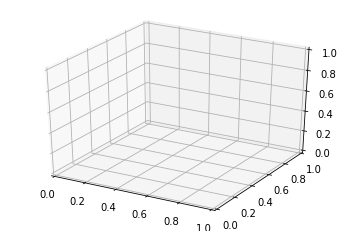

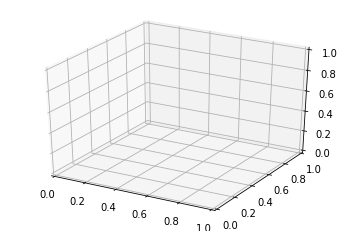

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')

start = timeit.timeit()
p = mp.Pool(4)
p.map(run_session_x, range(len(x_index)-1))
p.close()
p.join()

end = timeit.timeit()
print(-start+end)

start = timeit.timeit()
p = mp.Pool(4)
p.map(run_session_y, range(len(y_index)-1))
p.close()
p.join()

end = timeit.timeit()
print(-start+end)

print("Optimization Finished!")
   

with tf.Session() as sess:
    
 

Instructions for updating:
Use standard file APIs to check for files with this prefix.


ValueError: The passed save_path is not a valid checkpoint: /tmp/model.ckpt

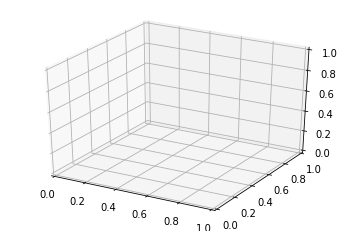

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess,"/tmp/model.ckpt")
    print(W1.eval())